In [7]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

data_dir = Path("../data")
plot_dir = Path("plots")

transactions = pl.scan_parquet(data_dir / "transactions_train_3.parquet").filter(pl.col("label") != "UNKNOWN")

In [44]:
foobi = (
 transactions.filter(pl.col("label") == "FRAUD").group_by("customer_feedback")
        .agg(pl.len().alias("count"))
        .with_columns((pl.col("count") / pl.col("count").sum()).alias("proportion"))
        .sort("count", descending=True)
)
foobi.collect()

customer_feedback,count,proportion
f64,u32,f64
null,4307,0.925043
10.0,332,0.071306
8.0,4,0.000859
6.0,4,0.000859
7.0,3,0.000644
9.0,2,0.00043
4.0,2,0.00043
2.0,1,0.000215
3.0,1,0.000215


In [42]:
foobi = (
 transactions.group_by("customer_feedback")
        .agg(pl.len().alias("count"))
        .with_columns((pl.col("count") / pl.col("count").sum()).alias("proportion"))
        .sort("count", descending=True)
)
foobi.collect()

customer_feedback,count,proportion
f64,u32,f64
null,137381,0.928093
10.0,8523,0.057578
9.0,518,0.003499
8.0,465,0.003141
7.0,331,0.002236
…,…,…
5.0,171,0.001155
4.0,136,0.000919
1.0,114,0.00077


In [24]:
df = (
    transactions
    .group_by("customer_feedback")
    .agg([
        pl.len().alias("total"),
        pl.col("label").filter(pl.col("label") == "FRAUD").count().alias("fraud_count")
    ])
    .with_columns(
        (pl.col("fraud_count") / pl.col("total")).alias("fraud_rate")
    )
    .select(["customer_feedback", "fraud_rate"])
).collect().to_pandas()

In [30]:
df

,customer_feedback,fraud_rate
0,3,0.011364
1,0,0.031351
2,9,0.003861
3,5,0.000000
4,2,0.017544
5,8,0.008602
6,6,0.016598
7,1,0.000000
8,4,0.014706
9,10,0.038953


In [31]:
label_counts = (
 transactions.group_by("label")
        .agg(pl.len().alias("count"))
        .with_columns((pl.col("count") / pl.col("count").sum()).alias("proportion"))
        .sort("count", descending=True)
)
label_counts.collect()

label,count,proportion
str,u32,f64
"""NORMAL""",143369,0.968546
"""FRAUD""",4656,0.031454


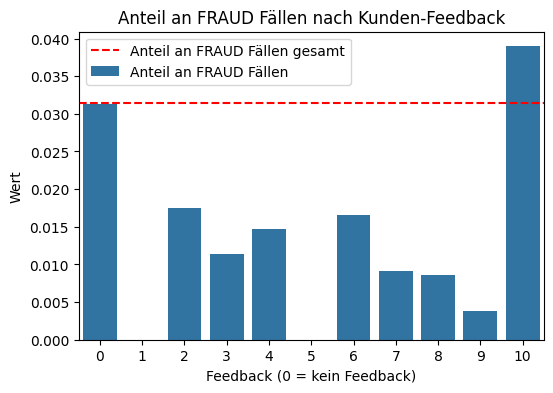

In [41]:
fraud_rate_total = label_counts.filter(pl.col("label") == "FRAUD").select("proportion").collect().to_numpy()[0][0]

df["customer_feedback"] = df["customer_feedback"].astype("Int64").fillna(0)

plt.figure(figsize=(6, 4))
sns.barplot(data=df, x='customer_feedback', y='fraud_rate', label='Anteil an FRAUD Fällen')

plt.axhline(fraud_rate_total, color='red', linestyle='--', label='Anteil an FRAUD Fällen gesamt')

plt.title('Anteil an FRAUD Fällen nach Kunden-Feedback')
plt.xlabel('Feedback (0 = kein Feedback)')
plt.ylabel('Wert')
plt.legend()

plt.savefig(plot_dir / "anteil_fraud_nach_feedback.png", dpi=300, bbox_inches='tight')
plt.show()